In [142]:
from ResearchMain import *

## 数据准备

### 演示数据集
泰坦尼克号数据结构分析：
- Pclass:乘客所持票类，有三种值(1：lower,2：middle,3：upper)
- Survived:0代表死亡，1代表存活
- Name:乘客姓名
- Sex:乘客性别(男：1，女：0)
- Age:乘客年龄(缺失值取平均值)
- SibSp:乘客兄弟姐妹/配偶的个数(整数值)
- Parch:乘客父母/孩子的个数(整数值)
- Ticket:票号(字符串)
- Fare:乘客所持票的价格(浮点数，0-500不等)
- Cabin:乘客所在船舱
- Embark:乘客登船港口:S、C、Q

In [143]:
# 读取演示数据集
# demo_data_name = 'pca_demo_titanic.csv'
# demo_data = pd.read_csv(DATA_PATH+demo_data_name, index_col='PassengerId')
# data.head(3)


In [144]:
# df = demo_data

### 读取分析数据

In [145]:
_ = all_df[[i for i in all_df.columns if
            isinstance(i, str) and (i.startswith('S') or i.endswith('-Ф'))]].replace(0, 0.00001)
sediment_df = _.drop(['S-Size-d((0.9-0.1)/0.5)', 'S-pH'], axis=1)

water_df = all_df[[i for i in all_df.columns if
                   isinstance(i, str) and i.startswith('W')]].replace(0, 0.00001)
water_df = water_df.drop(['W-PO_{4}^{3-}', 'W-TP'], axis=1)

df = sediment_df
df

,S-TN,S-TP,S-Size-d(0.1),S-Size-d(0.5),S-Size-d(0.9),Ⅰ-Ф,Ⅱ-Ф,Ⅲ-Ф,Ⅳ-Ф,Ⅴ-Ф
D-N1,705,806.285714,11.777,38.340,257.008,1201850.109,1570607.01,1.074539e+06,288732.5325,7.035140e+05
D-N2,320,794.285714,45.008,807.765,1239.506,2129004.270,2617675.11,9.851356e+05,360476.3250,6.234932e+05
D-N3,420,791.000000,611.957,875.213,1252.883,1463080.401,1806106.41,1.347911e+06,324498.2175,1.078437e+06
D-N4,650,768.000000,20.270,53.408,181.770,1556880.075,2017529.91,1.388097e+06,374268.4650,1.161176e+06
D-N5,1475,797.714286,9.567,40.619,116.947,1301272.695,2147362.11,1.412961e+06,219413.6775,1.005040e+06
...,...,...,...,...,...,...,...,...,...,...
W-H8,5325,956.571429,13.179,54.533,177.715,451096.641,887695.47,6.038852e+05,95290.0200,4.385763e+05
W-H9,5655,924.000000,12.406,46.868,175.772,988848.351,1400201.37,1.420681e+06,133869.1050,1.112571e+06
W-H10,4060,901.142857,12.816,45.730,169.597,485126.361,1032493.77,7.964262e+05,74844.0000,5.822210e+05
W-H11,4060,998.285714,13.281,56.314,187.891,424755.441,845680.77,8.486516e+05,113477.2200,6.512220e+05


## PCA分析

注意点：

1. 上面经过数据准备后，最后进行PCA分析的数据矩阵应命名为df；
2. 数据表不可以有空值；

### 预检验

首先进行KMO和Bartlett的检验，判断是否可以进行主成分分析。 对于KMO值：0.8上非常合适做主成分分析，0.7-0.8之间一般适合，0.6-0.7之间不太适合，0.5-0.6之间表示差，0.5下表示极不适合，对于 Bartlett的检验（p < 0.05,严格来说p < 0.01），若显著性小于0.05或0.01，拒绝原假设，则说明可以做主成分分析，若不拒绝原假设，则说明这些变量可能独立提供一些信息，不适合做主成分分析；

In [146]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# 巴特利特P值小于0.01，KMO值大于0.6；说明此数据适合做因子分析。
chi_square_value, p_value = calculate_bartlett_sphericity(df)  # 计算巴特利特P值
p_value

5.625544556547699e-131

In [147]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df)
kmo_model

0.502587111306986

<AxesSubplot:>

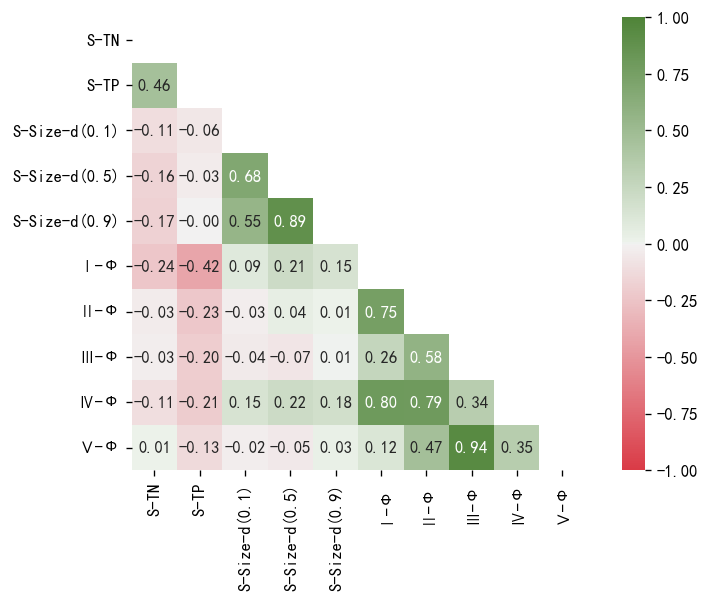

In [148]:
# 查看数据各列之间的相关性
matrix = df.corr()  # 获取各列之间的相关性，这个matrix其实就是X的协方差矩阵
mask = np.triu(np.ones_like(matrix, dtype=bool))  # mask掉上三角部分
plt.figure(figsize=(8, 5), dpi=120)
cmap = sns.diverging_palette(370, 120, n=80, as_cmap=True)
sns.heatmap(matrix, mask=mask, center=0, cmap=cmap, annot=True,
            square=True, fmt='.2f', vmax=1, vmin=-1)
# plt.title('泰坦尼克号数据集各列之间的相关性')

### 数据标准化

In [149]:
# 数据矩阵标准化与中心化
X = (df - df.mean()) / df.std(ddof=0)

这一步是主成分分析（PCA）的数据预处理，首先计算出矩阵中每一列的平均值，然后让每一列中的每一个元素都减去该列的平均值。在进行完这一步之后可以观察每一列数据的分散情况，如果列与列之间的差距仍过大，可以再计算出每一列的方差，然后再将减去平均值后的结果除以每一列的方差（这一步是可选步骤，叫做方差归一化）。

如果两步都做了，这个叫做数据的normalization——对一个非标准的正态分布随机变量转化为标准的正态分布随机变量。

这里一个注意点：
我们使用ddof=1样本标准偏差或ddof=0总体标准偏差作为参数来控制。

### 算法降维处理
在选取特征值的时候，要选取比较大的，特征值大的话数据方差就大，这也就意味着在经过降维后，可以最大程度上保留数据的差异性。

降维的过程实际就是寻找投影方向的过程。

从一个方面讲:

- 好的投影方向，可以使得投影误差最小化。
- 投影误差是各个数据点到投影点距离，这也就意味着经过降维处理后的损失达到最小。

从另一个方面讲:

- 好的投影方向，也就意味着在该方向投影的方差应该最大(分散度/区分度高)，可是使得信息在最大程度上得到保留。
- 复原误差小、重建容易。

降维的步骤：

目标：将n维数据降低为k维(k<n)。
（1）计算协方差矩阵：协方差矩阵（n×n）其实就是原数据矩阵中每两列之间的相关性系数；
（2）计算投影方向：对E进行奇异值分解(Singular Value Decomposition) [U,S,V] = svd (SIGMA)

其中U是一个nxn的矩阵，它每列是SIGMA的一个特征向量(线性代数概念)，U的前k列就是PCA的前k个投影向;我们将U的前k列记为投影矩阵P.
U的每一列都是一个特征向量，因此它的模长都为1，且特征向量之间都是正交的，乘积都为0

计算投影：

- 上一步我们得到了投影矩阵$P \in R^{n \times k}$；
- 对于第i个n维样本$x^{(i)}$，计算$z^{(i)} = x^{(i)} * P$，$z^{(i)}$就是降维后的第i个样本。

$$
X \in R^{m \times n} \times P \in R^{n \times k} = Z \in R^{m \times k}
$$


In [150]:
# X.to_csv('C:\\Users\\myxc\\Desktop\\demo.csv')

In [151]:
# SIGMA  # 各列之间的相关性（可以查看上面使用X.corr()命令获取矩阵X中各列之间的相关性所绘制的热图中的数据其实就是计算了矩阵X的协方差）
# 计算协方差矩阵（代表原矩阵中各列之间的相关性），@用来计算矩阵之间的乘法，.shape[0]获取矩阵中有多少行
SIGMA = (X.T @ X) / X.shape[0]
# 奇异值分解
U, S, V = np.linalg.svd(SIGMA)  # S 是个对角矩阵，是特征值，U是特征值对应的标准正交特征向量
# U
P = U[:, :2]  # 这里取U的前两列就是前两个投影的方向
# P
Z = X @ P  # Z就是经过降维后的矩阵
Z

,0,1
D-N1,0.120929,-0.535794
D-N2,3.642645,-6.118355
D-N3,4.150736,-10.567288
D-N4,1.376956,-0.135060
D-N5,0.338196,0.148125
...,...,...
W-H8,-2.550954,-0.620652
W-H9,-1.016957,0.036882
W-H10,-2.243792,-0.486490
W-H11,-2.326812,-0.578777


In [152]:
X = (df - df.mean()) / df.std(ddof=0)  # 获取经过Normalization的矩阵X
SIGMA = (X.T @ X) / X.shape[0]

# X.corr()
SIGMA  # SIGMA其实就是X.corr()


,S-TN,S-TP,S-Size-d(0.1),S-Size-d(0.5),S-Size-d(0.9),Ⅰ-Ф,Ⅱ-Ф,Ⅲ-Ф,Ⅳ-Ф,Ⅴ-Ф
S-TN,1.000000,0.458499,-0.110264,-0.164171,-0.172994,-0.240642,-0.032963,-0.029697,-0.105907,0.012774
S-TP,0.458499,1.000000,-0.056207,-0.032779,-0.000428,-0.420002,-0.231533,-0.197463,-0.208968,-0.127907
S-Size-d(0.1),-0.110264,-0.056207,1.000000,0.684153,0.547891,0.093714,-0.027701,-0.042172,0.147872,-0.023627
S-Size-d(0.5),-0.164171,-0.032779,0.684153,1.000000,0.890505,0.212443,0.040253,-0.065966,0.215413,-0.053673
S-Size-d(0.9),-0.172994,-0.000428,0.547891,0.890505,1.000000,0.153628,0.009264,0.007063,0.180121,0.025197
Ⅰ-Ф,-0.240642,-0.420002,0.093714,0.212443,0.153628,1.000000,0.751651,0.259756,0.802143,0.121607
Ⅱ-Ф,-0.032963,-0.231533,-0.027701,0.040253,0.009264,0.751651,1.000000,0.576475,0.791100,0.467455
Ⅲ-Ф,-0.029697,-0.197463,-0.042172,-0.065966,0.007063,0.259756,0.576475,1.000000,0.338386,0.941502
Ⅳ-Ф,-0.105907,-0.208968,0.147872,0.215413,0.180121,0.802143,0.791100,0.338386,1.000000,0.345010
Ⅴ-Ф,0.012774,-0.127907,-0.023627,-0.053673,0.025197,0.121607,0.467455,0.941502,0.345010,1.000000


In [153]:
# V
# ew, ev = np.linalg.eig(X.T.dot(X))
ew, ev = np.linalg.eig(np.cov(X.T))  # ew: 特征值，ev: 特征向量
ew_order = np.argsort(ew)[::-1]  # 将ew按照从大到小的顺序排列
# 特征根，主要是看主成分对于变量解释的贡献率（可以理解为究竟需要多少主成分才能把变量表达为100%），一般都要表达到90%以上才可以，否则就要调整因子数据。
ew_sort = ew[ew_order]
ev_sort = ev[:, ew_order]
print(ev_sort)

[[ 0.14833435  0.14427649 -0.45949484  0.51927169  0.53948106 -0.42358146
  -0.04759135 -0.0576114  -0.01595221  0.01015241]
 [ 0.2382428  -0.01483688 -0.47168222  0.43234807 -0.54827731  0.42744997
   0.14058386 -0.17010472  0.02384758 -0.03196315]
 [-0.13444466 -0.47139694 -0.16777732 -0.06058277  0.55580714  0.60985115
   0.08821144 -0.04114237 -0.18971704 -0.03979393]
 [-0.18534213 -0.5571721  -0.15994564  0.00803701 -0.07424702 -0.21938911
   0.10189923  0.11622081  0.73990645  0.06755628]
 [-0.17660618 -0.51632331 -0.21477722 -0.06001695 -0.29357471 -0.42099845
  -0.07091217 -0.00770249 -0.61799889 -0.04530895]
 [-0.43544843 -0.00606963  0.32955395  0.30464542  0.00476289 -0.07252683
   0.24338207 -0.6944297   0.03140174 -0.24738   ]
 [-0.45764736  0.18725599  0.01695862  0.27820247 -0.03853084  0.03716618
   0.48252377  0.6336309  -0.11681348 -0.16425966]
 [-0.35842421  0.27645539 -0.3782661  -0.32997811 -0.00706127 -0.01743332
   0.27566814 -0.23328296 -0.02557377  0.64164792]


### 方差解释表格
**图表说明:**
上表为总方差解释表格，主要是看主成分对于变量解释的贡献率（可以理解为究竟需要多少主成分才能把变量表达为100%），一般都要表达到90%以上才可以，否则就要调整因子数据。一般情况下,方差解释率越高，说明该主成分越重要，权重占比也应该越高。

方差解释表中，在主成分4时，总方差解释的特征根低于1，变量解释的贡献率达到74.899%，以上仅为参考。
若特征根小于1临界值过大，也可以集合具体情况具体分析。

In [154]:
# 输出一个方差解释表格
var_inter_0 = pd.DataFrame({'特征值': ew_sort})  # 添加特征值列
var_inter_0['百分比'] = (var_inter_0 / var_inter_0.sum())  # 添加百分比列
var_inter_0['累计百分比'] = var_inter_0['百分比'].cumsum()  # 计算累计百分比
var_inter = var_inter_0.copy()
var_inter['累计百分比'] = var_inter['累计百分比'].apply(lambda x: format(x, '.1%'))  # 保留一位小数
# var_inter_0['1'] = 1  # 前两列特征值大于1，且51%以上可以用来解释原来7个变量，因此取前两列
var_inter

,特征值,百分比,累计百分比
0,3.462325,0.342385,34.2%
1,2.511925,0.248401,59.1%
2,1.491449,0.147488,73.8%
3,1.201642,0.118829,85.7%
4,0.558144,0.055194,91.2%
5,0.448563,0.044358,95.7%
6,0.201121,0.019889,97.7%
7,0.136196,0.013468,99.0%
8,0.083269,0.008234,99.8%
9,0.017726,0.001753,100.0%


In [155]:
var_inter.to_clipboard()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

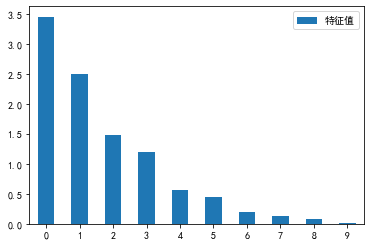

In [156]:
pd.DataFrame(ew_sort).plot(kind='bar').legend(
    ('特征值',))  # 添加图例必须多一个逗号，否则只显示第一个字符
plt.xticks(rotation=0)
# print(ev_sort)

In [157]:
# ev_sort[:, :2]  # 前两列就很大程度上可以用来解释原来7个变量，因此取前两列# V
V = ev_sort[:, :2]  # 前两列就很大程度上可以用来解释原来7个变量，因此取前两列
V

array([[ 0.14833435,  0.14427649],
       [ 0.2382428 , -0.01483688],
       [-0.13444466, -0.47139694],
       [-0.18534213, -0.5571721 ],
       [-0.17660618, -0.51632331],
       [-0.43544843, -0.00606963],
       [-0.45764736,  0.18725599],
       [-0.35842421,  0.27645539],
       [-0.45419069,  0.02136112],
       [-0.32219084,  0.26025572]])

### 因子数据表

In [158]:
# 构建一个因子数据表
factor_load_table = pd.DataFrame(V)  # 因子载荷数据表，可以分析到每个主成分中隐变量的重要性。
factor_load_table.index = df.columns
factor_load_table.columns = ['PCA 0', 'PCA 1']
factor_load_table.index.name = 'var'
factor_load_table['公共度'] = factor_load_table['PCA 0'] ** 2 + factor_load_table[
    'PCA 1'] ** 2  # 公因子方差：每个变量对应的PCA0与PCA1的平方和
factor_load_table

,PCA 0,PCA 1,公共度
var,,,
S-TN,0.148334,0.144276,0.042819
S-TP,0.238243,-0.014837,0.056980
S-Size-d(0.1),-0.134445,-0.471397,0.240290
S-Size-d(0.5),-0.185342,-0.557172,0.344792
S-Size-d(0.9),-0.176606,-0.516323,0.297780
Ⅰ-Ф,-0.435448,-0.006070,0.189652
Ⅱ-Ф,-0.457647,0.187256,0.244506
Ⅲ-Ф,-0.358424,0.276455,0.204895
Ⅳ-Ф,-0.454191,0.021361,0.206745


In [159]:
# 因子数据表的每一列的平方和相加等于1
factor_load_table.iloc[:,:2].applymap(lambda x: x**2).sum()

PCA 0    1.0
PCA 1    1.0
dtype: float64

In [160]:
# U的每一列都是一个特征向量，因此它的模长都为1，且特征向量之间都是正交的，乘积都为0
# (factor_load_table['PCA 0'] * factor_load_table['PCA 1']).sum()  # 两个特征向量的乘积应为0
# (factor_load_table['PCA 0']**2).sum()  # 每一个特征向量的模长都为1
# (factor_load_table['PCA 1']**2).sum()

<AxesSubplot:ylabel='var'>

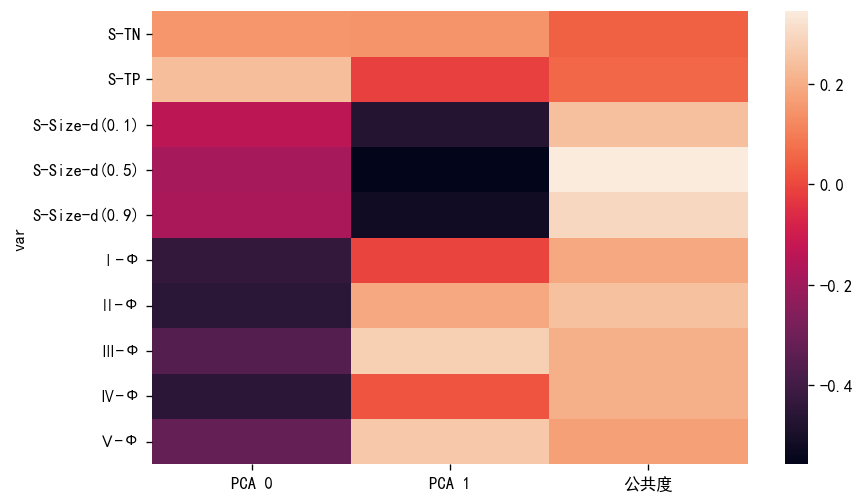

In [161]:
plt.figure(figsize=(8, 5), dpi=120)
sns.heatmap(factor_load_table)

### 绘图可视化

In [162]:
# X_new
X_new = X.dot(V)
# 将生存数据添加到DATaFrame中，用于绘制散点图的时候可以区分死亡与生存的区别
# X_new['Survived'] = train_data_0['Survived']
X_new

,0,1
D-N1,-0.120929,-0.535794
D-N2,-3.642645,-6.118355
D-N3,-4.150736,-10.567288
D-N4,-1.376956,-0.135060
D-N5,-0.338196,0.148125
...,...,...
W-H8,2.550954,-0.620652
W-H9,1.016957,0.036882
W-H10,2.243792,-0.486490
W-H11,2.326812,-0.578777


<AxesSubplot:xlabel='PCA 0', ylabel='PCA 1'>

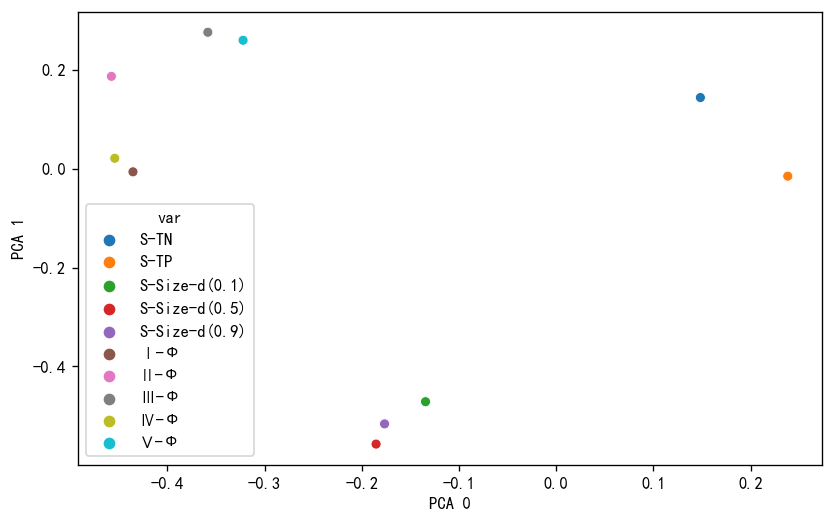

In [163]:
plt.figure(figsize=(8, 5), dpi=120)  # 设置绘图尺寸
sns.scatterplot(x=factor_load_table['PCA 0'],
                y=factor_load_table['PCA 1'], hue=factor_load_table.index)

### 成分矩阵表

In [164]:
# 成分矩阵表
composition_matrix = factor_load_table.loc[:, [
    'PCA 0', 'PCA 1']]  # 成分矩阵表 = 因子载荷数据表/对应每一个特征值
composition_matrix['PCA 0'] = composition_matrix['PCA 0'] / \
    ew_sort[0]  # 这里有个问题，有的软件里除的是根号下特征值，有的没有
composition_matrix['PCA 1'] = composition_matrix['PCA 1'] / ew_sort[1]
composition_matrix.round(3)

,PCA 0,PCA 1
var,,
S-TN,0.043,0.057
S-TP,0.069,-0.006
S-Size-d(0.1),-0.039,-0.188
S-Size-d(0.5),-0.054,-0.222
S-Size-d(0.9),-0.051,-0.206
Ⅰ-Ф,-0.126,-0.002
Ⅱ-Ф,-0.132,0.075
Ⅲ-Ф,-0.104,0.110
Ⅳ-Ф,-0.131,0.009


In [165]:
# composition_matrix.applymap(lambda x: x**2).sum()

图表说明：
上表为成分矩阵表，意在说明各个成分的所包含的因子得分系数（主成分载荷），用于计算出成分得分，得出因子公式，其计算公式为：线性组合系数*（方差解释率/累积方差解释率），最后将其归一化即为因子权重分。
线性组合系数，公式为：因子载荷系数除以对应特征根，即成分矩阵的系数。
智能分析：
模型的公式：
F1=-0.389×Pclass-0.254×Sex+0.099×Age+0.14×SibSp+0.214×Parch+0.45×Fare-0.212×Embarked
F2=0.262×Pclass-0.166×Sex-0.382×Age+0.411×SibSp+0.392×Parch-0.038×Fare+0.127×Embarked
由上可以得到：
F=(0.265/0.511)×F1+(0.245/0.511)×F2

### 因子权重分析表

In [166]:
factor_weight_analysis = pd.DataFrame(var_inter_0.loc[:1, ['百分比', '累计百分比']])
factor_weight_analysis['权重'] = factor_weight_analysis['百分比'] / \
    factor_weight_analysis['百分比'].sum()
factor_weight_analysis.index = ['PCA 0', 'PCA 1']
factor_weight_analysis.index.name = '主成分'
(factor_weight_analysis * 100).round(1).astype(str) + '%'  # 以保留一位小数、百分比的形式显示

,百分比,累计百分比,权重
主成分,,,
PCA 0,34.2%,34.2%,58.0%
PCA 1,24.8%,59.1%,42.0%


### 综合得分表（其实就是X_new中的数据）

In [167]:
comprehensive_score = pd.DataFrame(X_new.iloc[:, [0, 1]])
comprehensive_score.columns = ['PCA 0', 'PCA 1']
comprehensive_score['综合得分'] = comprehensive_score.iloc[:, 0] * factor_weight_analysis.loc[
    'PCA 0', '百分比'] + comprehensive_score.iloc[:, 1] * factor_weight_analysis.loc['PCA 1', '百分比']
comprehensive_score.sort_values(by='综合得分', ascending=False)  # 按照综合得分列倒序排列

,PCA 0,PCA 1,综合得分
W-N3,2.402839,-0.041986,0.812268
W-N10,2.632309,-0.471524,0.784137
W-N4,2.210367,0.082868,0.777382
W-H3,2.416737,-0.335957,0.744003
W-H8,2.550954,-0.620652,0.719239
...,...,...,...
D-H2,-3.399052,-0.080105,-1.183684
L-N8,-4.742928,0.995026,-1.376744
D-H5,-2.379477,-4.674540,-1.975861
D-N2,-3.642645,-6.118355,-2.766997


In [168]:
df.loc[comprehensive_score.sort_values(
    by='综合得分', ascending=False).head(5).index]  # 获取综合得分前五的人员

var,S-TN,S-TP,S-Size-d(0.1),S-Size-d(0.5),S-Size-d(0.9),Ⅰ-Ф,Ⅱ-Ф,Ⅲ-Ф,Ⅳ-Ф,Ⅴ-Ф
W-N3,5545,1342.285714,13.475,55.644,183.295,268745.121,1544057.37,1.342968e+06,109273.0500,1.208734e+06
W-N10,1475,1012.000000,11.234,42.248,159.245,115029.855,951302.07,1.005195e+06,47805.4575,7.727821e+05
W-N4,5490,1353.714286,13.610,47.021,150.020,433219.131,1640612.07,1.377087e+06,123711.5700,1.158552e+06
W-H3,6700,974.857143,11.228,47.731,159.858,492365.871,1202520.87,7.436378e+05,92495.7225,4.986894e+05
W-H8,5325,956.571429,13.179,54.533,177.715,451096.641,887695.47,6.038852e+05,95290.0200,4.385763e+05
